In [1]:
import sys
sys.path.append('/home/emastr/phd/')

from boundary_solvers.gauss_grid_2d import *
from boundary_solvers.geometry import *
import numpy as np
import matplotlib.pyplot as plt
from util.plot_tools import *
from boundary_solvers.blobs import *

### Define Domain

0.08181818181818182


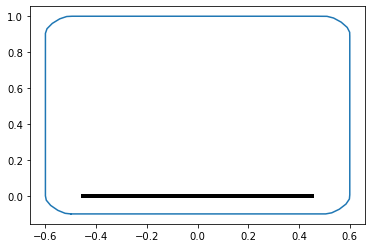

In [12]:
# 1) Fel i min testkod
# 2) Numerik funkar men inte analytisk
# 3) RoundedMicroGeom implementerar egen line adjoint

choice = 1

h, w = 1., 1.
eps = 0.1

f = lambda x: -np.ones_like(x) * eps
df = lambda x: np.zeros_like(x)
ddf = df


geom = RoundedMicroGeom(f, df, ddf, w, h, 0.1, 0, n_refine=3, n_corner_refine=0)

a = geom.line_left
b = geom.line_right
con = lambda z: np.conjugate(z)
mod = np.abs(b - a)
tan = (b - a) / mod
c = 1j / (h + eps)#np.exp(1j * 0.1 * np.pi)
k = eps / (h + eps)
if choice == 1:
    avg_anal = 1/(h+eps) * mod * eps
    davg_anal = 1/(h+eps) * mod
    sol = lambda z: (np.imag(z) + eps) / (h + eps) 
    condition = lambda t: sol(geom.eval_param(t=t))
elif choice == 2:
    avg_anal = np.real((c * con((b + a))/2 + k) * con(b-a))
    #avg_anal = (np.real(c * con((b + a)/2)*tan)) * mod + k * mod
    davg_anal = -np.real(-tan * c * 1j) * mod
    sol = lambda z: np.conjugate(z) * c + k
    condition = lambda t: sol(geom.eval_param(t=t))    
elif choice == 3:
    avg_anal = 0
    davg_anal = 0
    sol = lambda z: np.imag(np.conjugate(z) * c + k)*1j
    condition = lambda t: sol(geom.eval_param(t=t))

print(avg_anal)
geom.plot(plt.gca())

## Precomputing line averages in the interior
Next, we investigate the solution of the adjoint system, where the arguments in the kernel are switched. For example, if

\begin{equation}
    (\mathcal{K}v)(t) = \int_\Gamma \kappa(t,s)v(s)\mathrm{d}s,
\end{equation}

then the adjoint is obtained as

\begin{equation}
    (\mathcal{K}^* v)(t) = \int_\Gamma \kappa(s,t)v(s)\mathrm{d}s.
\end{equation}

Solving with respect to the adjoint is implemented as a part of the geometry. We use it to obtain mean velocity measurements across lines in the interior domain.

### Cauchy Condition (Riesz Vector Maximises Net Tangental Flow)

### Net Flow Test

For the field $u(z) = \overline{z}$, the net tangental flow across a line from $a \in \mathbb{C}$ to $b\in\mathbb{C}$ is exactly $\Re\left(\frac{b^2-a^2}{2}\right)$. We investigate if this formula holds.

Analytic: 0.08181818181818182. Numerical: 0.08181817875532488, 0.08181817875532488
Analytic: 0.08181818181818182. Numerical: 0.08181819657698715, 0.08181819657698715
Analytic deriv: 0.8181818181818181. Numerical: 0.8181816417812102
Analytic deriv: 0.8181818181818181. Numerical: 0.8181810821055346
Diff: 3.0628569402946226e-09
Numerical eval w. forward method: 0.08181814733033729


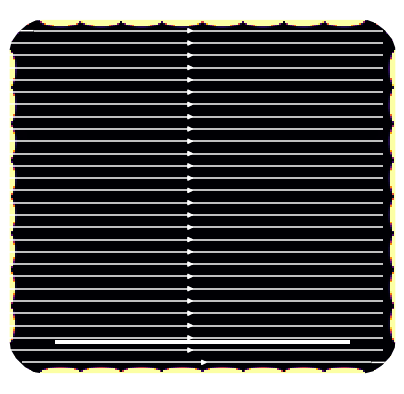

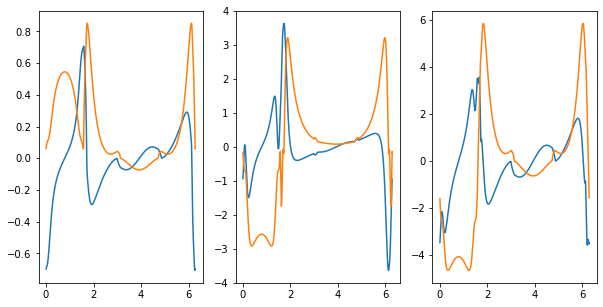

In [13]:
problem = StokesDirichletProblem(condition=condition, geometry=geom)
problem.solve(tol=1e-6)

riesz_vec, func = geom.precompute_line_avg(tol=1e-10, maxiter=200)
riesz_vec4, func4 = geom.line_eval_adjoint(tol=1e-10, maxiter=200)
riesz_vec2, func2 = geom.precompute_line_avg(derivative=1, tol=1e-10, maxiter=200)
riesz_vec3, func3 = geom.line_eval_adjoint(derivative=1, tol=1e-10, maxiter=200)

grid = geom.grid
t,_ = grid.get_grid_and_weights()
dz = geom.eval_param(derivative=1)
cond_t = problem.condition(t)
dens_t = problem.density

z_ev = np.array([w/2 + 1j * 0])

print(f"Analytic: {avg_anal}. Numerical: {func(cond_t)}, {geom.inner(1j*cond_t, riesz_vec)}")
print(f"Analytic: {avg_anal}. Numerical: {func4(dens_t)}, {geom.inner(dens_t, riesz_vec4)}")

print(f"Analytic deriv: {davg_anal}. Numerical: {func2(cond_t)}")
print(f"Analytic deriv: {davg_anal}. Numerical: {func3(dens_t)}")
print(f"Diff: {np.abs(avg_anal - func(cond_t))}")
print(f"Numerical eval w. forward method: {np.real(problem.evaluate(z_ev)*np.abs(b-a))}")

# Plot
plt.figure(figsize=(7,7))
problem.geometry.plot_field(ax=plt.gca(), func=lambda z: np.abs(problem.evaluate(z)-sol(z).T), \
                            apply_mask=True, cmap='inferno', vmax=1e-4)
problem.geometry.plot_stream(ax=plt.gca(), func=problem.evaluate, apply_mask=True, color='white')
problem.geometry.plot(ax=plt.gca(), color="white", linewidth=3)
plt.axis("equal")
remove_axes(plt.gca())

plt.figure(figsize=(10,5))
plt.subplot(1,3,1)
plt.plot(t, np.real(riesz_vec))
plt.plot(t, np.imag(riesz_vec))

plt.subplot(1,3,2)
plt.plot(t, np.real(riesz_vec3))
plt.plot(t, np.imag(riesz_vec3))

plt.subplot(1,3,3)
plt.plot(t, np.real(riesz_vec2))
plt.plot(t, np.imag(riesz_vec2))

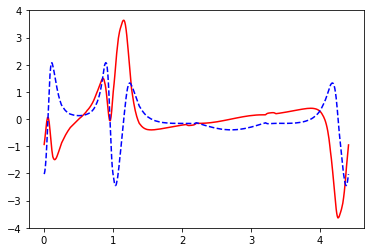

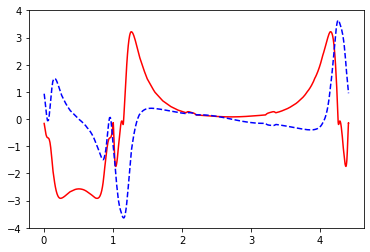

In [4]:
# Testa så att line_eval_adjoint funkar

## print(f"{a}, {b}")
log = lambda z: np.log(np.abs(z)) + 1j * np.angle(z)

# Conjugate operator
c = lambda z: np.conjugate(z)
im = lambda z: np.imag(z)

# Tangent vector
da = b-a      
e = da / 1j / np.abs(da) 

g = geom.eval_param()
dg = geom.eval_param(derivative=1)
ga = g - a
gb = g - b
log_ba = log(gb / ga) / da
ga_gb = ga * gb
#riesz_vec4 = (da * np.imag(- dg * log(dgb / dga) / da) \
#            + np.imag(dac * dg) * log(np.conjugate(dgb / dga)) / dac \
#            + np.imag(dga * dac) * dgc / np.conjugate(dga * dgb))/ np.pi

riesz_vec4 = -(- da * im(dg * e  / ga_gb) 
              - im(c(e) * dg) * c(da / ga_gb) \
              + 2*c(e) *im(dg * c(da)) / c(ga_gb)\
              - im(ga * c(da)) * c(e * dg * (ga + gb) / ga_gb ** 2)) / np.pi / np.abs(dg)

        
t, w = grid.get_grid_and_weights()
dz = geom.eval_param(derivative=1)
arc = np.cumsum(np.abs(dz) * w)
    
plt.plot(arc, np.real(riesz_vec3), 'r')
plt.plot(arc, np.real(riesz_vec4), 'b--')

plt.figure()
plt.plot(arc, np.imag(riesz_vec3), 'r')
plt.plot(arc, np.imag(riesz_vec4), 'b--')

## Operator Spectra


In [7]:
def coimage(A):
    A = np.atleast_2d(A)
    _, _, vh = np.linalg.svd(A)
    ns = vh[:-1].conj().T
    return ns

K = geom.stokes_matrix()
Kt = geom.stokes_adjoint_matrix()

V = coimage(Kt)
U = Kt @ V
B = (V.T @ Kt.T @ Kt @ V)

def solve_adjoint(b):
    return V @ np.linalg.solve(B, U.T @ b)


3269.195359694047
3 smallest eigenvalues: [0.18164409+0.j 0.18164731+0.j 0.3382192 +0.j]
cond. no: 63.28683639352356
3 smallest eigenvalues: [0.18164409+0.j 0.18164769+0.j 0.4299938 +0.j]
cond. no: 57.70171450752247


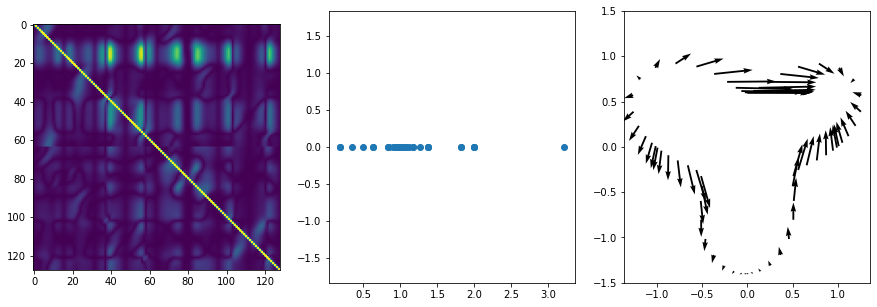

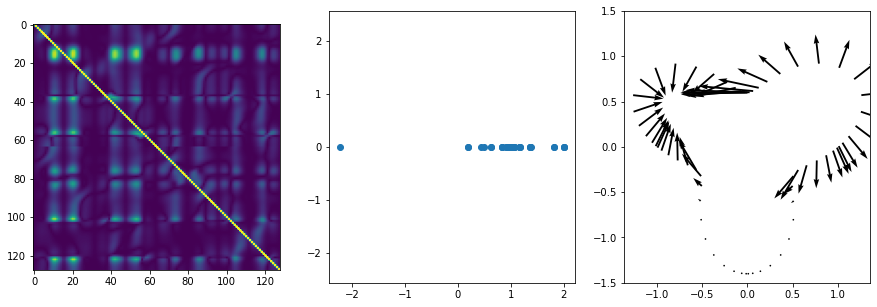

In [8]:
print(np.linalg.cond(B))

z = geom.eval_param()
dz = geom.eval_param(derivative=1)
ddz = geom.eval_param(derivative=2)


n = len(z)

for A in (K, Kt):
    res = np.linalg.eig(A)
    eig = res[0]
    vec = res[1]

    arg = np.argsort(np.abs(eig))
    eig = eig[arg]
    vec = vec[:,arg]

    plt.figure(figsize=(15,5))
    plt.subplot(1,3,1)
    plt.imshow(np.abs(A), vmax=.5)

    plt.subplot(1,3,2)
    plt.scatter(np.real(eig), np.imag(eig))
    plt.axis("equal")
    print(f"3 smallest eigenvalues: {eig[:3]}")
    
    plt.subplot(1,3,3)
    #plt.figure(figsize=(10,10))
    #plt.plot(vec[:,0])
    n = len(z)
    plt.quiver(np.real(z), np.imag(z), np.real(vec[n:,0]), -np.real(vec[:n,0]), scale=1)
    #plt.quiver(np.real(z), np.imag(z), np.imag(dz), -np.real(dz), scale=20, color='red')
    #plt.quiver(np.real(z), np.imag(z), np.real(ddz), np.imag(ddz), scale=20, color='blue')
    #plt.quiver(np.real(z), np.imag(z), np.real(c), np.imag(c), scale=1, color='green')
    plt.axis("equal")
    plt.xlim([-1.5,1.5])
    plt.ylim([-1.5,1.5])
    
    print(f"cond. no: {np.linalg.cond(A)}")
    #print(A[:n,:n].sum(axis=1))
    #print(A[n:,:n].sum(axis=1))

## Define Micro Domain With Shape Parameters

In [9]:
from boundary_solvers.gauss_grid_2d import GaussLegGrid
# Grid
segments = np.linspace(0,2*np.pi,5)
corners = np.ones_like(segments).astype(int)
grid = GaussLegGrid(segments=segments, corners=corners)
grid.refine_all_nply(1)
grid.refine_corners_nply(1)
t,_ = grid.get_grid_and_weights()

##### GEOMETRY ############
m = 2
L = 1
H = 2
eps = 0.1
dt = 0.2 * np.pi

### Floor
f = lambda t: eps*(-1 + np.cos(4 * m * t + dt))*1j + L * t/(0.5*np.pi)
df = lambda t: eps*(-(4 * m) * np.sin(4 * m * t + dt))*1j + L/(0.5*np.pi)
ddf = lambda t: eps*(-(4 * m)**2 * np.cos(4 * m * t + dt))*1j

### Stitch boundary
segments = np.linspace(0, 2*np.pi, 5)
r, dr, ddr = GaussLegGeometry.get_line_2d(f(.5*np.pi), H*1j+L, 0.5 * np.pi, 1.0 * np.pi)
u, du, ddu = GaussLegGeometry.get_line_2d(H*1j+L     , H*1j  , 1.0 * np.pi, 1.5 * np.pi)
l, dl, ddl = GaussLegGeometry.get_line_2d(H*1j       , f(0)  , 1.5 * np.pi, 2.0 * np.pi)

z = GaussLegGeometry.stitch_functions_1d([f,r,u,l], segments)
dz = GaussLegGeometry.stitch_functions_1d([df,dr,du,dl], segments)
ddz = GaussLegGeometry.stitch_functions_1d([ddf,ddr,ddu,ddl], segments)
geom = GaussLegGeometry([z,dz,ddz], grid=grid)


###### PROBLEM ############
condition = lambda t: np.conjugate(z(t))
problem = StokesDirichletProblem(condition=condition, geometry=geom)


eps2 = 0.1 # To combat rounding error
gamma = 0.4
a = gamma * 1j + eps2
b = gamma * 1j + L - eps2

### Geometry of the line, "H"
eps2 = 0.1 
gamma = 0.5
a = gamma * 1j + eps2
b = gamma * 1j + L - eps2

###### SOLVE ##############
problem.solve(verbose=True, tol = 1e-6, maxiter=40)
riesz_vec, func = geom.precompute_line_avg(a,b,derivative=0,tol=1e-10, maxiter=100)
riesz_vec2, func2 = geom.precompute_line_avg(a,b,derivative=1,tol=1e-10, maxiter=100)

###### PLOT ##############
print(f"Average of tangental component of velocity = {func(condition(t))}, analytic={np.real(b**2 - a**2)/2}")
print(f"Average of tangental component of normal derivative  = {func2(condition(t))}, analytic={np.imag((b-a)**2)/np.abs(b-a)}")
print(f"Shear stress alpha  = {- func(condition(t)) / func2(condition(t))}")

plt.figure(figsize=(15,7))

# Subplot 1
plt.subplot(1,2,1)
problem.geometry.plot_field(ax=plt.gca(), func=lambda z: np.abs(problem.evaluate(z)), \
                            apply_mask=True, cmap='inferno', vmax=4)
problem.geometry.plot_stream(ax=plt.gca(), func=problem.evaluate, apply_mask=True, color='white')
problem.geometry.plot(ax=plt.gca(), color="black", linewidth=3)
plt.plot([np.real(a), np.real(b)], [np.imag(a), np.imag(b)], '-', color='white', linewidth=3)
plt.axis("equal")
remove_axes(plt.gca())


# Subplot 2
plt.subplot(1,2,2)
geom.plot(ax=plt.gca(), shownormals=True, showpts=True)
plt.quiver(np.real(z(t)), np.imag(z(t)), np.real(riesz_vec), np.imag(riesz_vec), color="red",zorder=2, scale=10)
plt.axis("equal")
remove_axes(plt.gca())


# Plot
plt.figure()
plt.plot(t, np.real(riesz_vec))
plt.plot(t, np.imag(riesz_vec))
plt.plot(t, np.imag(riesz_vec))

NameError: name 'GaussLegGeometry' is not defined

In [22]:
%timeit geom.precompute_line_avg(a, b, derivative=1, tol=1e-13, maxiter=200, verbose=True)
%timeit geom.line_eval_adjoint(a, b, derivative=0, tol=1e-13, maxiter=200)

Converged in 0 iterations
Converged in 0 iterations
Converged in 0 iterations
Converged in 0 iterations
Converged in 0 iterations
Converged in 0 iterations
Converged in 0 iterations
Converged in 0 iterations
Converged in 0 iterations
Converged in 0 iterations
Converged in 0 iterations
Converged in 0 iterations
Converged in 0 iterations
Converged in 0 iterations
Converged in 0 iterations
Converged in 0 iterations
Converged in 0 iterations
Converged in 0 iterations
Converged in 0 iterations
Converged in 0 iterations
Converged in 0 iterations
Converged in 0 iterations
Converged in 0 iterations
Converged in 0 iterations
Converged in 0 iterations
Converged in 0 iterations
Converged in 0 iterations
Converged in 0 iterations
Converged in 0 iterations
Converged in 0 iterations
Converged in 0 iterations
Converged in 0 iterations
Converged in 0 iterations
Converged in 0 iterations
Converged in 0 iterations
Converged in 0 iterations
Converged in 0 iterations
Converged in 0 iterations
Converged in

Let's try more realistic boundary conditions, with zero slip at the floor.

0
Average of tangental component of velocity = 0.38758720888606213
Average of tangental component of normal derivative  = 0.749844231271762
Shear stress alpha  = -0.5168902989740958


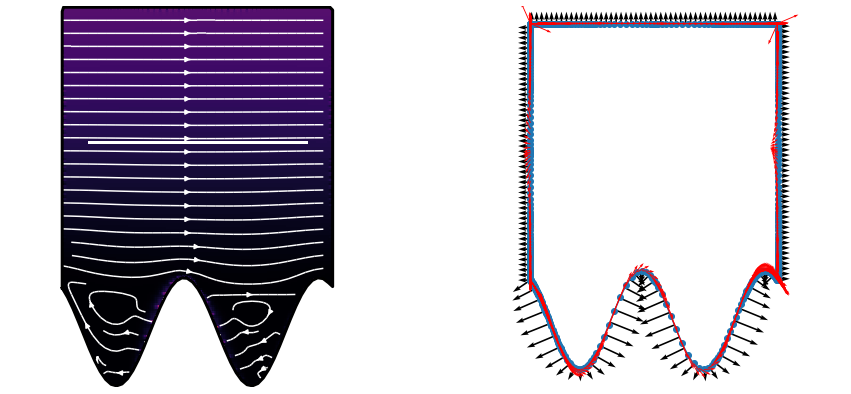

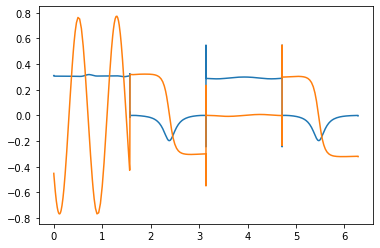

In [23]:
# Grid
segments = np.linspace(0,2*np.pi,5)
corners = np.ones_like(segments).astype(int)
grid = GaussLegGrid(segments=segments, corners=corners)
grid.refine_all_nply(1)
grid.refine_corners_nply(5)
t,_ = grid.get_grid_and_weights()

##### GEOMETRY ############
m = 2
L = 1
eps = 0.2
dt = 0.2 * np.pi
H = 1

### Floor
f = lambda t: eps*(-1 + np.cos(4 * m * t + dt))*1j + L * t/(0.5*np.pi)
df = lambda t: eps*(-(4 * m) * np.sin(4 * m * t + dt))*1j + L/(0.5*np.pi)
ddf = lambda t: eps*(-(4 * m)**2 * np.cos(4 * m * t + dt))*1j

### Stitch boundary
r, dr, ddr = GaussLegGeometry.get_line_2d(f(.5*np.pi), H*1j+L, 0.5 * np.pi, 1.0 * np.pi)
u, du, ddu = GaussLegGeometry.get_line_2d(H*1j+L     , H*1j  , 1.0 * np.pi, 1.5 * np.pi)
l, dl, ddl = GaussLegGeometry.get_line_2d(H*1j       , f(0)  , 1.5 * np.pi, 2.0 * np.pi)

z = GaussLegGeometry.stitch_functions_1d([f,r,u,l], segments)
dz = GaussLegGeometry.stitch_functions_1d([df,dr,du,dl], segments)
ddz = GaussLegGeometry.stitch_functions_1d([ddf,ddr,ddu,ddl], segments)
geom = GaussLegGeometry([z,dz,ddz], grid=grid)


###### PROBLEM ############
condition = lambda t: np.clip(np.imag(z(t)), 0, 1)
problem = StokesDirichletProblem(condition=condition, geometry=geom)

### Geometry of the line, "H"
eps2 = 0.1 
gamma = 0.5
a = gamma * 1j + eps2
b = gamma * 1j + L - eps2

###### SOLVE ##############
problem.solve(verbose=True, tol = 1e-6, maxiter=40)
riesz_vec, func = geom.precompute_line_avg(a,b,derivative=0,tol=1e-10, maxiter=100)
riesz_vec2, func2 = geom.precompute_line_avg(a,b,derivative=1,tol=1e-10, maxiter=100)

###### PLOT ##############
print(f"Average of tangental component of velocity = {func(condition(t))}")
print(f"Average of tangental component of normal derivative  = {func2(condition(t))}")
print(f"Shear stress alpha  = {- func(condition(t)) / func2(condition(t))}")

plt.figure(figsize=(15,7))

# Subplot 1
plt.subplot(1,2,1)
problem.geometry.plot_field(ax=plt.gca(), func=lambda z: np.abs(problem.evaluate(z)), \
                            apply_mask=True, cmap='inferno', vmax=4)
problem.geometry.plot_stream(ax=plt.gca(), func=problem.evaluate, apply_mask=True, color='white')
problem.geometry.plot(ax=plt.gca(), color="black", linewidth=3)
plt.plot([np.real(a), np.real(b)], [np.imag(a), np.imag(b)], '-', color='white', linewidth=3)
plt.axis("equal")
remove_axes(plt.gca())


# Subplot 2
plt.subplot(1,2,2)
geom.plot(ax=plt.gca(), shownormals=True, showpts=True)
plt.quiver(np.real(z(t)), np.imag(z(t)), np.real(riesz_vec), np.imag(riesz_vec), color="red",zorder=2, scale=10)
plt.axis("equal")
remove_axes(plt.gca())


# Plot
plt.figure()
plt.plot(t, np.real(riesz_vec))
plt.plot(t, np.imag(riesz_vec))

In [10]:
print(np.linalg.cond(geom.stokes_adjoint_matrix()))

721.3468723264895
